In [1]:
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import math
import numpy as np
import sklearn as skl

In [114]:
weather_data = pd.read_csv('weather_data.csv')
traffic_data = pd.read_csv('traffic_data.csv')

In [115]:
weather_data.columns

Index(['Unnamed: 0', 'STATION', 'NAME', 'DATE', 'AWND', 'PRCP', 'SNOW', 'SNWD',
       'TAVG', 'TMAX', 'TMIN', 'WT01', 'WT02', 'WT03', 'WT05', 'WT07', 'WT08',
       'WT10', 'DATETIME', 'WT10.1', 'WT11', 'WT13', 'WT14', 'WT16', 'WT21'],
      dtype='object')

Group the weather data into months

In [3]:
def date_to_month(date:str):
    dt = datetime.datetime.fromisoformat(date)
    return dt.month
def date_to_year(date:str):
    dt = datetime.datetime.fromisoformat(date)
    return dt.year

In [124]:
weather_data['DATETIME'] = list(map(datetime.datetime.fromisoformat,weather_data.DATE))

In [116]:
weather_data['Year'] = list(map(date_to_year,weather_data.DATE))
weather_data['Month'] = list(map(date_to_month,weather_data.DATE))

In [117]:
traffic_data['Year'] = list(map(date_to_year,traffic_data.DATETIME))
traffic_data['Month'] = list(map(date_to_month,traffic_data.DATETIME))

In [118]:
combined_data = traffic_data[['TOTAL','Month','Year']]

In [132]:
weather_data = weather_data.fillna(0)

In [133]:
numbercols = [x for x in weather_data.columns if weather_data[x].dtype in ['int64','float64']]
numbercols.remove('Unnamed: 0')
combined_cols = numbercols+['Year','Month','Total']
average_func = lambda x: pd.DataFrame([np.average(x[numbercols],axis=0)],columns=numbercols)

In [ ]:
for z in range(weather_data.shape[0]):
    if weather_data.loc[z,'TAVG'] == 0:
        weather_data.loc[z,'TAVG'] = [np.mean(x) for x in weather_data[['TMAX','TMIN']].values][z]

In [182]:
combined_averaged = {}
for x in combined_cols: combined_averaged[x] = []
for _,x in traffic_data.iterrows():
    z = weather_data.where((x.Year == weather_data.Year) & (x.Month == weather_data.Month)).dropna()
    if not z.empty:
        row = average_func(z)
        row['Year'] = x.Year
        row['Month'] = x.Month
        row['Total'] = x.TOTAL
        for col in row.columns:
            combined_averaged[col].append(row[col][0])

In [183]:
dataset = pd.DataFrame(combined_averaged)
dataset['Datetime'] = list(map(lambda ym: datetime.date(ym[1]['Year'],ym[1]['Month'],28),dataset[['Year','Month']].iterrows()))

In [184]:
dataset.pop('SNOW')
dataset.pop('SNWD')

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
223    0.0
224    0.0
225    0.0
226    0.0
227    0.0
Name: SNWD, Length: 228, dtype: float64

In [142]:
from sklearn.impute import SimpleImputer
test_impute = SimpleImputer(missing_values=0).fit_transform(X=[weather_data.TAVG])

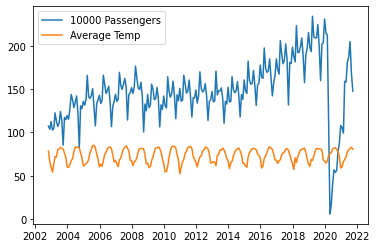

In [188]:
plt.plot(dataset.Datetime,dataset.Total/10000,label='10000 Passengers')
plt.plot(dataset.Datetime,dataset.TAVG,label='Average Temp')
plt.legend()

In [189]:
dataset['Covid'] = np.where(dataset.Datetime>datetime.datetime(2019,3,28,1,1,1).date(),1,0)

In [190]:
data = dataset[dataset.columns.drop(['Datetime','Total'])]
labels = dataset.Total

In [191]:
from sklearn.preprocessing import RobustScaler
from sklearn import pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso,LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.linear_model

In [194]:
xr,xt,yr,yt = train_test_split(data,labels,train_size=150)

In [241]:
linreg = LinearRegression()
linreg.fit(xr,yr)
linreg.score(xt.values,yt)

/Users/kiran/opt/anaconda3/envs/p310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


0.159264097569489

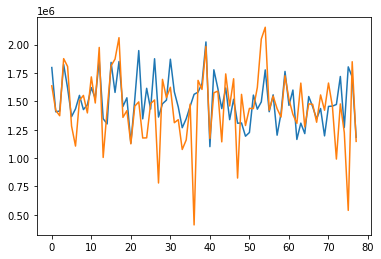

In [242]:
plt.plot(linreg.predict(xt))
plt.plot(yt.values)

In [243]:
ridge = Ridge()
ridge.fit(xr,yr)
ridge.score(xt,yt)

0.30967463989463595

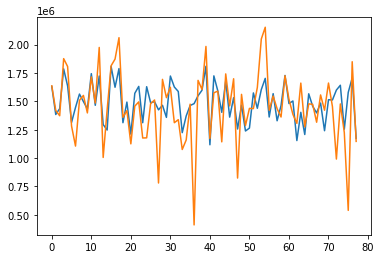

In [244]:
plt.plot(ridge.predict(xt))
plt.plot(yt.values)

In [245]:
logreg = LogisticRegression()
logreg.fit(xr,yr)
logreg.score(xt,yt)

/Users/kiran/opt/anaconda3/envs/p310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.0

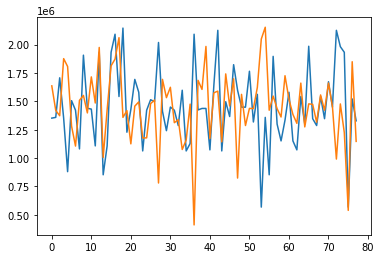

In [246]:
plt.plot(logreg.predict(xt))
plt.plot(yt.values)

In [247]:
lasso = Lasso()
lasso.fit(xr,yr)
lasso.score(xt,yt)

/Users/kiran/opt/anaconda3/envs/p310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.378e+12, tolerance: 1.897e+09
  model = cd_fast.enet_coordinate_descent(


0.15774194758850013

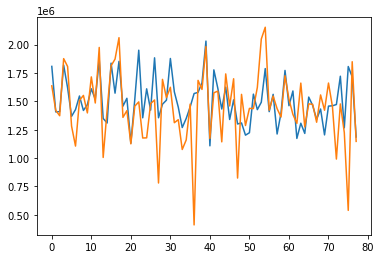

In [251]:
plt.plot(lasso.predict(xt))
plt.plot(yt.values)

In [231]:
import sklearn.metrics as metrics
for x in [logreg,linreg,ridge,lasso]:
    print(metrics.mean_absolute_error(yt,x.predict(xt)),x.score(xt,yt))

312498.5512820513 0.0
187619.06283084207 0.159264097569489
167462.7880814853 0.30967463989463595
187633.96415120555 0.15774194758850013
